# TinyMS ResNet50 Tutorial

In this tutorial, starting a ResNet50 inference server and making predictions using TinyMS API will be demonstrated. 

## Prerequisite
 - Ubuntu: `18.04`
 - Python: `3.7.x`
 - Flask: `1.1.2`
 - MindSpore: `CPU-1.1.1`
 - TinyMS: `0.1.0`
 - numpy: `1.17.5`
 - opencv-python: `4.5.1.48`
 - Pillow: `8.1.0`
 - pip: `21.0.1`
 - requests: `2.18.4`
 
## Introduction

TinyMS is a high-level API which is designed for amateur of deep learning. It minimizes the number of actions of users required to construct, train, evaluate and serve a model. TinyMS also provides tutorials and documentations for developers. 

In this tutorial, the ckpt files will be provided since training ResNet50 on CPU is time consuming, so there are four steps to start a server and making predicts: `get the ckpt files`, `define servable json`, `start the server` and `making predicts` in which the server will be started in a subprocess.

In [1]:
import os
import json
from PIL import Image
from tinyms.serving import start_server, predict, list_servables, shutdown, server_started

[WARNING] ME(27491:139750375483200,MainProcess):2021-03-16-17:03:08.170. [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


## Steps

### 1. Get the ckpt file

In this tutorial, we provide two resnet50 checkpoint files, one is trained with [ImageNet2012](http://www.image-net.org/challenges/LSVRC/2012/) dataset, another is trained with [cifar10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset. A ResNet50 ckpt file is required for the backend to run the prediction. We recommend downloading our pretrained checkpoint files, click [resnet_imagenet](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/imagenet2012/resnet50.ckpt) to download resnet-imagenet ckpt file and click [resnet_cifar](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/resnet50.ckpt) to download resnet-cifar ckpt file. Save this file to `/etc/tinyms/serving/resnet50_<dataset_name>/resnet50.ckpt`.

Or run the following code to download the `resnet_imagenet` and `resnet_cifar` ckpt file:

In [2]:
# check lenet folder exists or not, and download resnet50_imagenet
imagenet2012_ckpt_folder = '/etc/tinyms/serving/resnet50_imagenet2012'
imagenet2012_ckpt_path = '/etc/tinyms/serving/resnet50_imagenet2012/resnet50.ckpt'
if not os.path.exists(imagenet2012_ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/resnet50_imagenet2012
    !wget -P /etc/tinyms/serving/resnet50_imagenet2012 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/imagenet2012/resnet50.ckpt
else:
    print('imagenet2012 ckpt folder already exists')
    if not os.path.exists(imagenet2012_ckpt_path):
        !wget -P /etc/tinyms/serving/resnet50_imagenet2012 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/imagenet2012/resnet50.ckpt   
    else:
        print('imagenet2012 ckpt file already exists')


# check lenet folder exists or not
cifar10_ckpt_folder = '/etc/tinyms/serving/resnet50_cifar10'
cifar10_ckpt_path = '/etc/tinyms/serving/resnet50_cifar10/resnet50.ckpt'
if not os.path.exists(cifar10_ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/resnet50_cifar10
    !wget -P /etc/tinyms/serving/resnet50_cifar10 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/resnet50.ckpt
else:
    print('cifar10 ckpt folder already exists')
    if not os.path.exists(cifar10_ckpt_path):
        !wget -P /etc/tinyms/serving/resnet50_cifar10 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/resnet50.ckpt
    else:
        print('cifar10 ckpt file already exists')

imagenet2012 ckpt folder already exists
--2021-03-16 17:03:10--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/imagenet2012/resnet50.ckpt
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.90, 49.4.112.5, 49.4.112.113, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188521005 (180M) [binary/octet-stream]
Saving to: ‘/etc/tinyms/serving/resnet50_imagenet2012/resnet50.ckpt’

resnet50.ckpt       100%[===================>] 179.79M  52.4MB/s    in 3.6s    

2021-03-16 17:03:14 (49.8 MB/s) - ‘/etc/tinyms/serving/resnet50_imagenet2012/resnet50.ckpt’ saved [188521005/188521005]

cifar10 ckpt folder already exists
--2021-03-16 17:03:14--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/resnet50.ckpt
Resolving ascend-

### 2. Define servable.json 

Choose only one of the following two code blocks to define the servable json file which will be used later

Run this code to define the servable json file for `ResNet50_imagenet2012` model:

In [3]:
servable_json = [{'name': 'resnet50_imagenet2012', 
                  'description': 'This servable hosts a resnet50 model predicting mushrooms', 
                  'model': {
                      "name": "resnet50", 
                      "format": "ckpt", 
                      "class_num": 9}}]
os.chdir("/etc/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

Or run this code to define the servable json file for `ResNet50_cifar10` model:

In [ ]:
servable_json = [{'name': 'resnet50_cifar10', 
                  'description': 'This servable hosts a resnet50 model predicting 10 classes of objects', 
                  'model': {
                      "name": "resnet50", 
                      "format": "ckpt", 
                      "class_num": 10}}]
os.chdir("/etc/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

### 3. Start server

#### 3.1 Introduction
TinyMS Serving is a C/S(client/server) structure. There is a server and client. TinyMS using [Flask](https://flask.palletsprojects.com/en/1.1.x/) which is a micro web framework written in python as the C/S communication tool. In order to serve a model, user must start server first. If successfully started, the server will be run in a subprocess and listening to POST requests from 127.0.0.1 port 5000 sent by client and handle the requests using MindSpore backend which will construct the model, run the prediction and send the result back to the client.  

#### 3.2 start server
Run the following code block to start the server:

In [4]:
start_server()

Server starts at host 127.0.0.1, port 5000


### 4. Make predictions

#### 4.1 Upload the pic

A picture is required to be the input. The `resnet_imagenet` ckpt requires a mushroom picture, while the `resnet_cifar` ckpt requires a picture of 
```
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
```
Click [mushroom](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/mushrooms/mushroom.jpeg) which is used in this tutorial for `resnet_imagenet` and [airplane](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/objects/airplane.jpg) for `resnet-cifar`. Upload the pic, if using terminal, either `scp` or `wget` will do, if running in Jupyter, click `Upload` button at the top right and select the picture. Save the picture at the root folder, rename to `mushroom.jpeg`(for resnet-imagenet) or `airplane.jpg`(for resnet-cifar).

Or run this code to download `mushroom` pic for `resnet_imagenet`  and `airplane` for `resnet_cifar`:

In [5]:
# download mushroom pic
if not os.path.exists('/root/mushroom.jpeg'):
    !wget -P /root/ https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/mushrooms/mushroom.jpeg
else:
    print('mushroom.jpeg already exists')

# download airplane pic
if not os.path.exists('/root/airplane.jpg'):
    !wget -P /root/ https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/objects/airplane.jpg
else:
    print('airplane.jpg already exists')

--2021-03-16 17:03:26--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/mushrooms/mushroom.jpeg
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.90, 49.4.112.5, 49.4.112.113, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76020 (74K) [image/jpeg]
Saving to: ‘/root/mushroom.jpeg’

mushroom.jpeg       100%[===================>]  74.24K  --.-KB/s    in 0.08s   

2021-03-16 17:03:26 (948 KB/s) - ‘/root/mushroom.jpeg’ saved [76020/76020]

--2021-03-16 17:03:26--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/objects/airplane.jpg
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.90, 49.4.112.5, 49.4.112.113, ...
Connecting to ascend-

####  4.2 List servables

Now, use `list_servables` function to check what model is servable right now.

In [6]:
list_servables()

[{'description': 'This servable hosts a resnet50 model predicting mushrooms',
  'model': {'class_num': 9, 'format': 'ckpt', 'name': 'resnet50'},
  'name': 'resnet50_imagenet2012'}]

If the output description shows it is a `resnet50` model, run the following code which will automatically detect whether it is a imagenet model or a cifar model

#### 4.3 Sending request and get the result

Run `predict` function to send the request, select between `TOP1_CLASS` and `TOP5_CLASS` to check the output

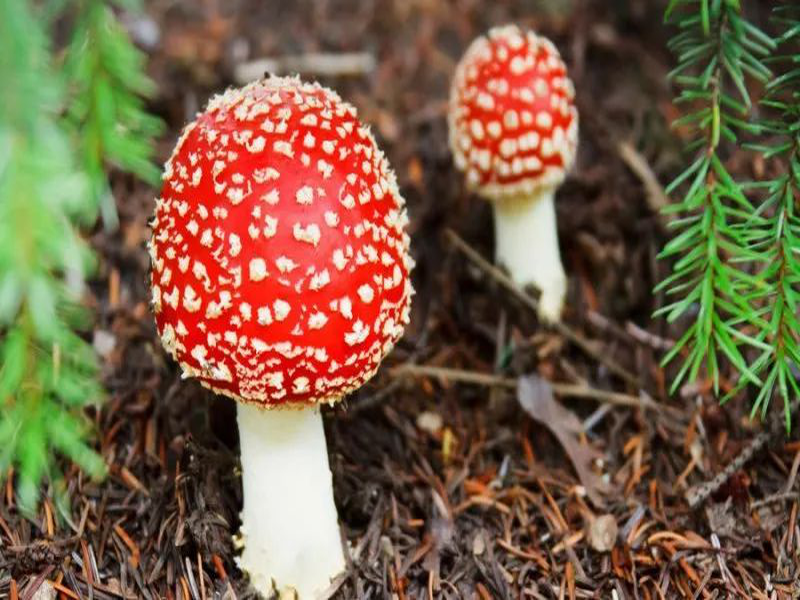

TOP1: Amanita毒蝇伞,伞菌目,鹅膏菌科,鹅膏菌属,主要分布于我国黑龙江、吉林、四川、西藏、云南等地,有毒, score: 0.99750286340713500977


In [7]:
# set image_path and output strategy
imagenet_image_path = "/root/mushroom.jpeg"
cifar_image_path = "/root/airplane.jpg"
strategy = "TOP1_CLASS"

# predict(image_path, servable_name, dataset_name, strategy='TOP1_CLASS')
if server_started() is True:
    servable_name = list_servables()[0]['name']
    if servable_name == 'resnet50_imagenet2012':
        display(Image.open(imagenet_image_path).resize((800, 600), Image.ANTIALIAS))
        print(predict(imagenet_image_path, "resnet50_imagenet2012", "imagenet2012", strategy))
    else:
        display(Image.open(cifar_image_path).resize((800, 600), Image.ANTIALIAS))
        print(predict(cifar_image_path, "resnet50_cifar10", 'cifar10', strategy))
else:
    print('Server not started')

## Check output

If user runs `resnet_imagenet` and see output similar to this:
```
TOP1: Amanita毒蝇伞,伞菌目,鹅膏菌科,鹅膏菌属,主要分布于我国黑龙江、吉林、四川、西藏、云南等地,有毒, score: 0.99119007587432861328
```
that means the prediction result is returned and the inference is completed.

Or user runs `resnet_cifar`, and the output is expected to be like this:
```
TOP1: airplane, score: 0.99997282028198242188
```

 ## Change model
 
Run another `servable_json` code block.
 
## Shutdown server

In [8]:
shutdown()

'Server shutting down...'